In [1]:
import pandas as pd
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import one_hot
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

The provided script defines a custom dataset class named OfflineDataset designed for handling offline data. 

- The script reads data from multiple CSV files, concatenates them into a single pandas DataFrame, and performs preprocessing steps.
- Preprocessing includes filtering out rows with non-positive 'memory_usage' and 'cpu_usage', and computing the logarithm of 'response_time', storing it as 'response_time_log'.
- Replica, cpu and heap features are discrete values indicating the type or configuration of the server being used
- The feature 'expected_tps' represents the expected number of transactions per second

In [2]:
class OfflineDataset(Dataset):
    def __init__(self, 
                input_cols=['replica','cpu','heap','expected_tps'],
                output_cols=['response_time_log','num_request','cpu_usage','memory_usage']):
        super().__init__()
        self.input_cols = input_cols
        self.output_cols = output_cols
        self.df = self._read_data()
        self.df_org = self.df.copy(deep=True)
        self.input_transform, self.output_transform  = self.transform()

    def transform(self):
        input_transform = {}
        output_transform = {}
        
        for idx, col in enumerate(self.input_cols):
            if col in ['replica','cpu','heap']:
                shift = self.df[col].median()
                divide = 1
            elif col in ['expected_tps']:
                shift = self.df[col].mean()
                divide = self.df[col].std()
            else:
                shift = 0
                divide = 1
            self.df[col] = (self.df[col] - shift )/divide
            input_transform[idx] = {'col': col, 'idx': idx, 'shift': shift, 'divide': divide}

        for idx, col in enumerate(self.output_cols):
            if col in ['response_time']:
                shift = self.df[col].mean()
                divide = self.df[col].std()
            elif col in ['num_request','response_time_log']:
                shift = 0
                divide = self.df[col].max()
            else:
                shift = 0
                divide = 1
            self.df[col] = (self.df[col] - shift )/divide
            output_transform[idx] = {'col': col, 'idx': idx, 'shift': shift, 'divide': divide}
        return input_transform, output_transform

    def inv_transform(self, x: torch.tensor, input=False) -> torch.tensor:
        if input:
            transform = self.input_transform
        else:
            transform = self.output_transform
        x_transform = [x[:,idx].unsqueeze(1)*tr['divide'] + tr['shift'] for idx, tr in transform.items()]
        return torch.concat(x_transform, dim=1).detach().numpy()
        

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        input = [torch.tensor([row[col]]) for col in self.input_cols]
        output = [torch.tensor([row[col]]) for col in self.output_cols]
        
        input = torch.concat(input).to(torch.float)
        output = torch.concat(output).to(torch.float)
       
        return input, output

    def getshapes(self):
        x, y = self.__getitem__(0)
        input_size = (len(self.df), len(x))
        output_size = (len(self.df), len(y))
        return input_size, output_size
            
    def _read_data(self) -> pd.DataFrame:
        df = pd.read_csv('server_client_v4/output_300_1.csv')
        for i in ['2','3','4']:
            df_tmp = pd.read_csv(f'server_client_v4/output_300_{i}.csv')
            df = pd.concat([df, df_tmp])

        for i in ['1','2','3']:
            df_tmp = pd.read_csv(f'server_client_v4/output_browse_300_data_{i}.csv')
            df = pd.concat([df, df_tmp])

        df = df[(df['memory_usage'] > 0) & (df['cpu_usage'] > 0)]
        df['response_time_log'] = np.log10(df['response_time'])

        return df

In [3]:
class StateEstimator(nn.Module):
    def __init__(self, in_features: int, out_features: int, 
                 loss_fn=torch.nn.functional.mse_loss):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.loss_fn = loss_fn

        layer_size = [40,50]
        self.input_layer = nn.Sequential(
            nn.BatchNorm1d(num_features=in_features)
        )

        self.layer_0 = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=layer_size[0]),
            nn.GELU(),
            nn.BatchNorm1d(num_features=layer_size[0]),
        )

        self.layer_1 = nn.Sequential(
            nn.Linear(in_features=layer_size[0], out_features=layer_size[1]),
            nn.GELU(),
            nn.BatchNorm1d(num_features=layer_size[1]),
        )

        self.output_layer = nn.Sequential(
            nn.Linear(in_features=layer_size[-1],out_features=out_features),
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.input_layer(x)
        out = self.layer_0(out)
        out = self.layer_1(out)
        out = self.output_layer(out)
        return out
    

    def predict(self, dataloader):
        with torch.no_grad():
            predictions = torch.empty(0, self.out_features)
            targets = torch.empty(predictions.shape)
            for x, y in dataloader:
                y_pred = self.forward(x)
                predictions = torch.cat([predictions, y_pred], dim=0)
                targets = torch.cat([targets, y], dim=0)
            return predictions, targets
    
    def evaluate(self, dataloader):
        with torch.no_grad():
            avg_loss = 0
            for x, y in dataloader:
                y_pred = self.forward(x)
                loss = self.loss_fn(y_pred, y)
                avg_loss += loss.item()
            avg_loss = avg_loss / len(dataloader) 
            return avg_loss


In [4]:
def mape_loss_fn(output, target):
    return torch.mean(torch.abs((target - output) / target))

def scatter(pred, target, metric_names):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    for ax, i, title in zip(axes.flatten(), range(4), metric_names):
        ax.scatter(target[:,i], pred[:,i])
        ax.plot(target[:,i], target[:,i])
        ax.set_xlabel('target')
        ax.set_ylabel('prediction')
        ax.set_title(title)


100%|██████████| 100/100 [01:06<00:00,  1.50it/s, epoch=99, loss=0.0866, val_loss=0.111]


Training   loss: 0.09263816256015027
Validation loss: 0.10684817476618674


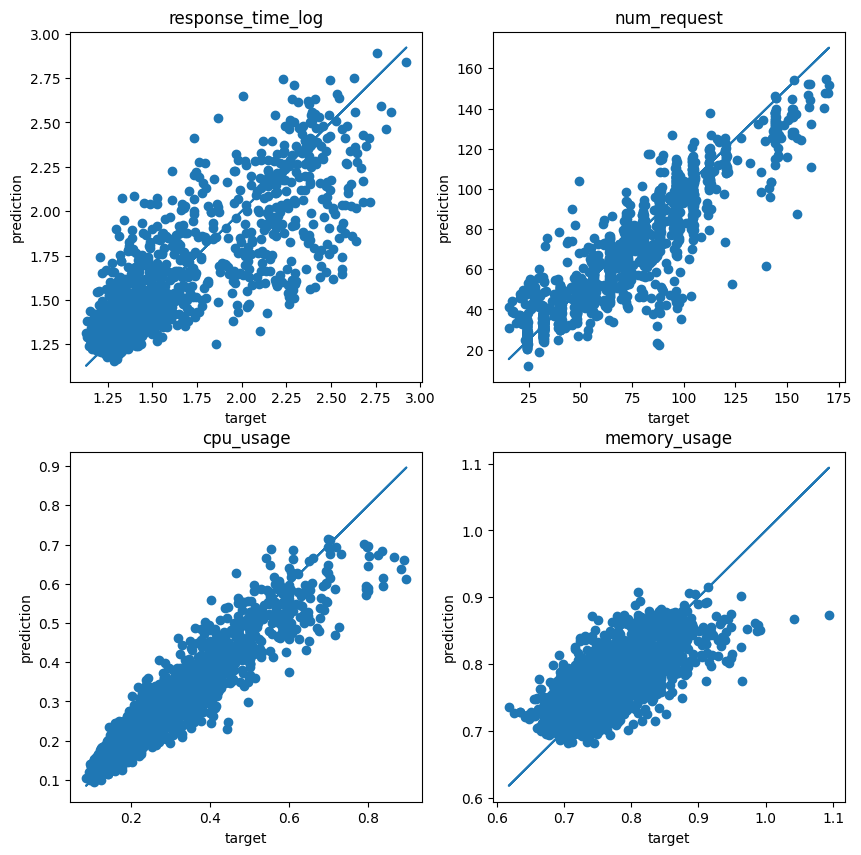

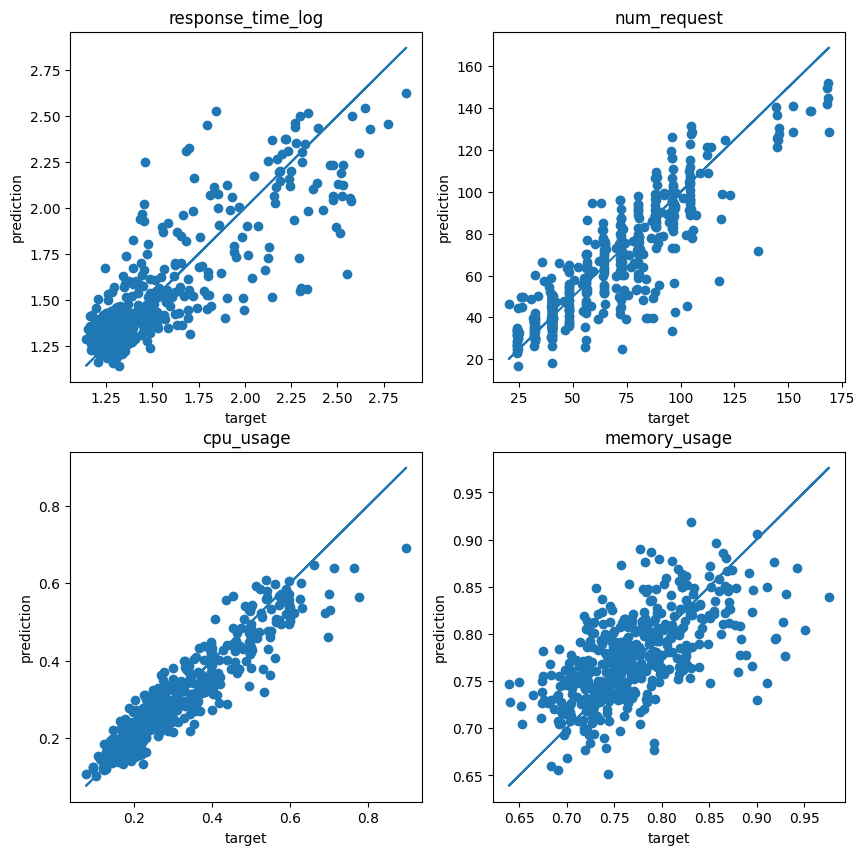

In [5]:
seed = 42
trn_ratio = 0.8
batch_size_trn = 32
batch_size_val = 16
max_epoch = 100
loss_fn = mape_loss_fn

torch.manual_seed(seed)
ds = OfflineDataset()
df_orig = ds._read_data()

trn_size = int(len(ds)*trn_ratio)
val_size = len(ds) - trn_size
ds_trn, ds_val = torch.utils.data.random_split(ds, [trn_size, val_size])
dl_trn = DataLoader(ds_trn, batch_size=batch_size_trn, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size_val, shuffle=True)

x, y = ds.getshapes()
_, in_features = x
_, out_features = y

state_estimator = StateEstimator(in_features=in_features, out_features=out_features, loss_fn=loss_fn)
optim = torch.optim.Adam(state_estimator.parameters())


epochbar = tqdm(range(max_epoch))
for ep in epochbar:
    state_estimator.train()
    pbar = tqdm(dl_trn)
    for x, y in pbar:
        optim.zero_grad()
        y_pred = state_estimator(x)
        loss = loss_fn(y_pred, y)
        pbar.set_postfix(loss=loss.item())
        loss.backward()
        optim.step()

    val_loss = state_estimator.evaluate(dl_val)
    epochbar.set_postfix(epoch=ep,loss=loss.item(),val_loss=val_loss)

pred_trn, target_trn = state_estimator.predict(dl_trn)
pred_val, target_val = state_estimator.predict(dl_val)

scatter(ds.inv_transform(pred_trn), ds.inv_transform(target_trn), ds.output_cols)
scatter(ds.inv_transform(pred_val), ds.inv_transform(target_val), ds.output_cols)


trn_loss = state_estimator.evaluate(dl_trn)
val_loss = state_estimator.evaluate(dl_val)
print(f'Training   loss: {trn_loss}')
print(f'Validation loss: {val_loss}')


state_estimator.eval()
df = ds.df




In [6]:

def reward(input_state, output_state): 
    replica, cpu, heap, expected_tps = input_state
    response_time_log, num_request, cpu_usage, memory_usage = output_state
    speed = 1 if 10**response_time_log < 20 else 20/(10**response_time_log)
    performance = 0.5 * min(num_request/expected_tps, 1) + 0.5 * speed 
    utilization = 0.5 * min(cpu_usage / (cpu / 10), 1) + 0.5 * min(memory_usage / (heap / 10), 1)
    r = 0.8 * performance  + 0.2 * utilization
    return r


def policy(expected_tps):
    max_reward = -np.Infinity

    for replica in pd.unique(df['replica']):
        for cpu in pd.unique(df['cpu']):
            for heap in pd.unique(df['heap']):
                state = torch.from_numpy(np.array([replica, cpu, heap, expected_tps])).to(torch.float)
                input_state = state[None, :]

                output_state = state_estimator(input_state)
                input_state_org = ds.inv_transform(input_state, input=True).squeeze()
                output_state_org = ds.inv_transform(output_state, input=False).squeeze()
                replica_org, cpu_org, heap_org, expected_tps_org = input_state_org

                r = reward(input_state_org, output_state_org)
                if r > max_reward:
                    max_reward = r
                    best_action = (replica_org, cpu_org, heap_org, expected_tps_org)
                    best_state = output_state_org

                    df_avg = ds.df_org.query(f'expected_tps == {expected_tps_org} and replica=={replica_org} and cpu == {cpu_org} and heap == {heap_org}').mean()
                    real_state = df_avg[ds.output_cols].to_numpy()

    return best_action, best_state, real_state
print(f'{"replica":>7s} {"cpu":>3s} {"heap":>4s} {"exp_tps":>10s} '+\
      f'{"resp_time":>10s} {"obs_tps":>10s} {"cpu_use":>10s} {"mem_use":>10s} '+\
      f'{"resp_time_r":>12s} {"obs_tps_r":>10s} {"cpu_use_r":>10s} {"mem_use_r":>10s}')
for tps in sorted(pd.unique(df['expected_tps'])):
    chosen_action, best_state, real_state = policy(tps)
    replica, cpu, heap, tps = chosen_action
    response_time_log, num_request, cpu_usage, memory_usage = best_state
    response_time_log_real, num_request_real, cpu_usage_real, memory_usage_real = real_state
    print(f'{replica:7.0f} {cpu:3.0f} {heap:4.0f} {tps:10.2f} '+\
          f'{10**response_time_log:10.2f} {num_request:10.2f} {cpu_usage:10.3f} {memory_usage:10.3f} '+\
          f'{10*response_time_log_real:12.2f} {num_request_real:10.2f} {cpu_usage_real:10.3f} {memory_usage_real:10.3f}')


replica cpu heap    exp_tps  resp_time    obs_tps    cpu_use    mem_use  resp_time_r  obs_tps_r  cpu_use_r  mem_use_r
      1   8    5      24.00      19.46      30.76      0.206      0.726          nan        nan        nan        nan
      1   8    5      32.00      19.82      37.12      0.240      0.728          nan        nan        nan        nan
      1   9    4      40.00      19.65      43.89      0.290      0.724          nan        nan        nan        nan
      1   9    4      48.00      19.66      51.10      0.328      0.720        12.06      48.20      0.316      0.675
      1   9    4      56.00      19.51      58.34      0.366      0.713        13.22      56.23      0.431      0.741
      1   9    4      64.00      19.28      65.42      0.402      0.707        13.17      64.00      0.409      0.708
      1   9    4      72.00      19.12      72.22      0.436      0.701        12.07      72.40      0.413      0.669
      1   9    4      80.00      19.18      78.70      0

In [ ]:
model_scripted = torch.jit.script(state_estimator)
model_scripted.save('state_estimator.pt') 